# 楽曲データの特徴量抽出

In [1]:
# ファイルを開いたら一番最初に実行してください
import numpy as np
import matplotlib.pyplot as plt
import os
import librosa
import librosa.display
import IPython

(1323000,)


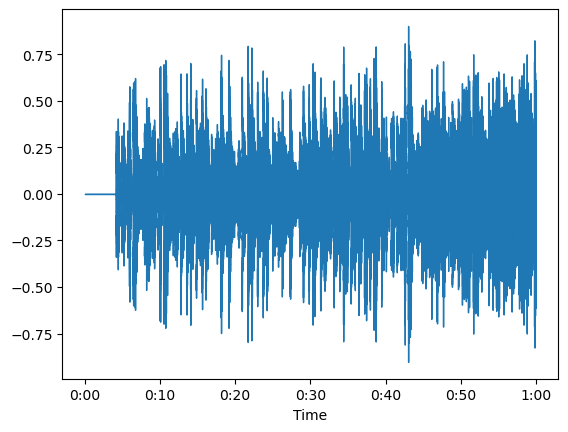

In [9]:
y, sr = librosa.load('music_data/joyful/joyful3.mp3', offset=0.0, duration=60.0)
print(y.shape)
librosa.display.waveshow(y)

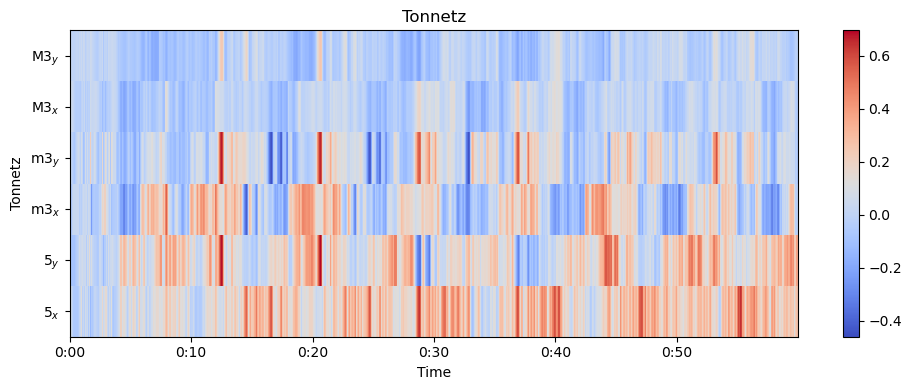

In [3]:
# トーンネット特徴量の抽出
tonnetz = librosa.feature.tonnetz(y=y, sr=sr)

# トーンネット特徴量のプロット
plt.figure(figsize=(10, 4))
librosa.display.specshow(tonnetz, y_axis='tonnetz', x_axis='time')
plt.colorbar()
plt.title('Tonnetz')
plt.tight_layout()
plt.show()

In [7]:
tonnetz.shape

(6, 2584)

In [5]:
y_harmonic, y_percussive = librosa.effects.hpss(y, margin=3.0)

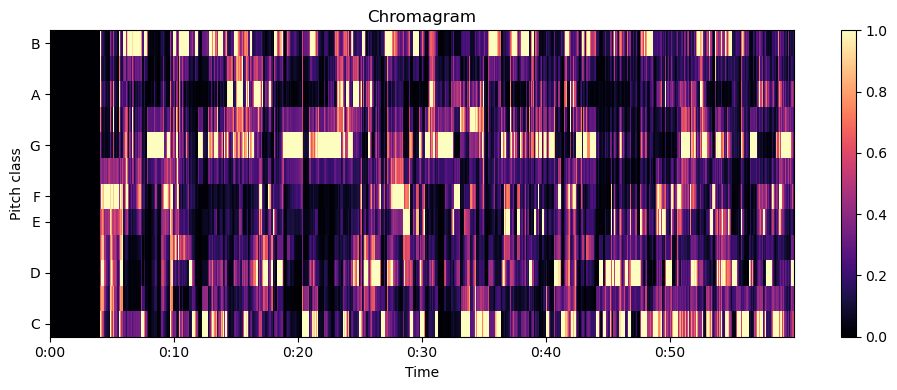

In [3]:
# クロマ特徴量の抽出
chroma = librosa.feature.chroma_stft(y=y, sr=sr)

# クロマ特徴量のプロット
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chromagram')
plt.tight_layout()
plt.show()

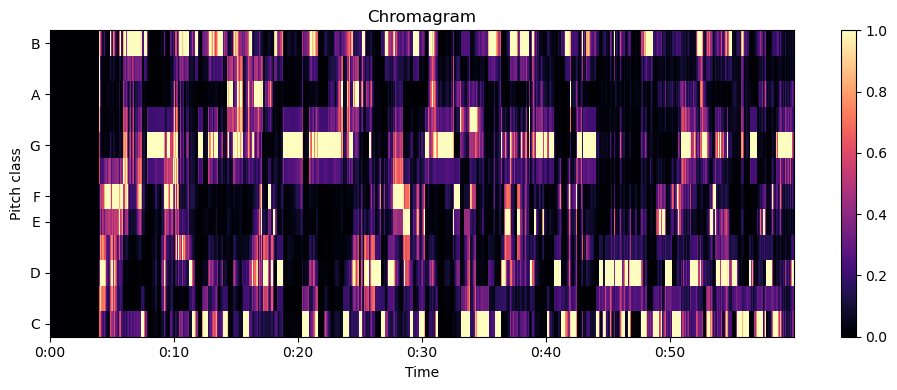

In [6]:
# クロマ特徴量の抽出
chroma = librosa.feature.chroma_stft(y=y_harmonic, sr=sr)

# クロマ特徴量のプロット
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chromagram')
plt.tight_layout()
plt.show()

In [7]:
chroma

array([[0.        , 0.        , 0.        , ..., 0.36758152, 0.3760899 ,
        0.3586231 ],
       [0.        , 0.        , 0.        , ..., 0.28128663, 0.2887795 ,
        0.32615605],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.2700574 , 0.26493427,
        0.21491995],
       [0.        , 0.        , 0.        , ..., 0.05682039, 0.05663016,
        0.05120764],
       [0.        , 0.        , 0.        , ..., 0.07310531, 0.08015361,
        0.08261287]], dtype=float32)

(1025, 2584)


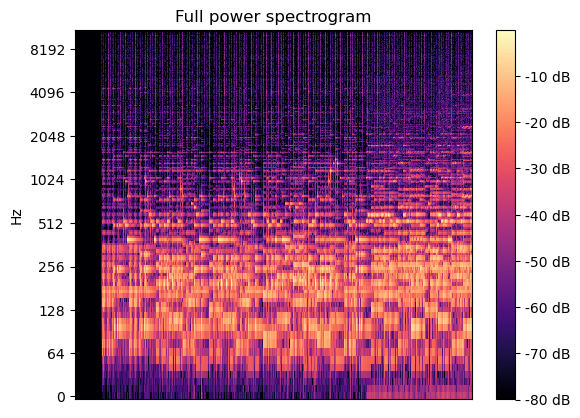

In [3]:
# 短時間フーリエ変換
D = librosa.stft(y)
print(D.shape)

# スペクトグラムを描画
plt.figure()
librosa.display.specshow(librosa.amplitude_to_db(np.abs(D), ref=np.max), y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Full power spectrogram')
plt.show()

In [4]:
# 短時間フーリエ変換
D = librosa.stft(y)
print(D.shape)
# 各時間点の振幅を得る
amplitude_spectrum = np.abs(D)
# モデルが学習しやすくするために対数変換
Y = np.log(amplitude_spectrum+1e-9)
# 正規化
normalized_spectrum = (Y - np.min(Y)) / (np.max(Y) - np.min(Y))
#  

(1025, 2584)


(20, 2584)
[-549.0517  -549.0517  -549.0517  ... -177.99377 -166.54507 -144.73859]


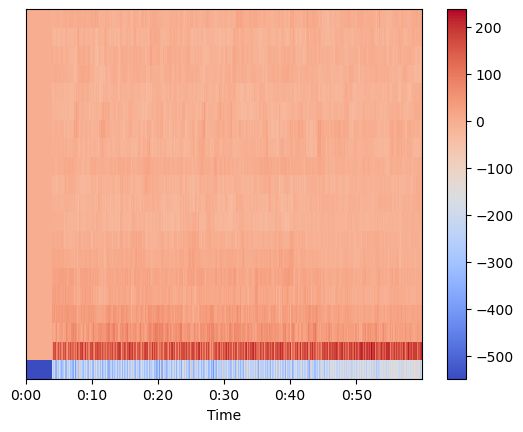

In [5]:
# メル周波数ケプストラム
mfccs = librosa.feature.mfcc(y=y, sr=sr)
print(mfccs.shape)
print(mfccs[0])
import librosa.display

librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.colorbar()

In [6]:
y_harmonic, y_percussive = librosa.effects.hpss(y, margin=3.0)

In [16]:
Y_percussive = np.log(np.abs(librosa.stft(y_percussive))+1e-9)
percussive_spectral_novelty = None
n_freq, n_tf = Y_percussive.shape
percussive_spectral_novelty = np.zeros(n_tf)
for f in range(0, n_freq):
    tmp = Y_percussive[f,1:] - Y_percussive[f,:-1]
    tmp[tmp<0.0] = 0.0 # 半整流波
    tmp = np.append(tmp, 0.0)
    percussive_spectral_novelty += tmp
percussive_spectral_novelty /= np.max(percussive_spectral_novelty)

print(percussive_spectral_novelty.shape)

(2584,)


In [8]:
import scipy.signal

# def compute_lpc_cepstrum(y, sr, order):
#     # LPC係数の計算
#     lpc_coeffs = librosa.lpc(y, order)

#     # LPCケプストラム係数の導出
#     lpc_cepstrum = np.fft.irfft(np.log(np.abs(np.fft.rfft(lpc_coeffs))+1e-9))
#     return lpc_cepstrum

# 音声ファイルの読み込み
audio_path = 'music_data/positive/positive1.mp3'  # 音声ファイルのパスを指定
y, sr = librosa.load(audio_path, offset=0.0, duration=60.0)
# LPC係数の計算
lpc_coeffs = librosa.lpc(y, order=13)
# LPCケプストラム係数の導出
lpc_cepstrum = np.fft.irfft(np.log(np.abs(np.fft.rfft(lpc_coeffs))+1e-9))

print(lpc_coeffs)

[ 1.         -1.3138756   0.12305821 -0.1211137   0.38414252 -0.15512267
  0.20888257 -0.11779439  0.2531356  -0.42858326  0.16058385 -0.0619444
  0.17500252 -0.08420807]


In [22]:
from scipy.signal import lfilter
from scipy.signal.windows import hamming

# MP3ファイルの読み込み
y, sr = librosa.load('music_data/negative/negative100.mp3', sr=None, offset=0.0, duration=60.0)

# フレームの長さとステップサイズ（サンプリングレートに依存）
frame_length = int(0.050 * sr)  # 25 ms
frame_step = int(0.020 * sr)    # 10 ms

# オーディオをフレームに分割
frames = librosa.util.frame(y, frame_length=frame_length, hop_length=frame_step)

# LPCケプストラム係数の計算
lpc_order = 20
kepstral_coefficients = []

for frame in frames.T:
    frame = frame * hamming(len(frame))  # ハミング窓の適用
    lpc_coef = librosa.lpc(frame, order=lpc_order)  # LPC係数の計算
    lpc_kepstra = np.fft.ifft(np.log(np.abs(np.fft.fft(lpc_coef, n=512))))  # ケプストラムの計算
    kepstral_coefficients.append(lpc_kepstra[:lpc_order+1])  # 最初の20個の係数を保存

kepstral_coefficients = np.array(kepstral_coefficients)

In [26]:
from scipy.interpolate import interp1d

# データをリサンプリングする関数
def resample_features(data, target_length):
    x_old = np.linspace(0, 1, data.shape[0])
    x_new = np.linspace(0, 1, target_length)
    interpolator = interp1d(x_old, data, axis=0, kind='linear')
    return interpolator(x_new)

# LPCケプストラム係数の実部を取得
kepstral_coefficients = np.abs(kepstral_coefficients)

# LPCケプストラム係数をリサンプリング
kepstral_coefficients = resample_features(kepstral_coefficients, 2584)

print(kepstral_coefficients)

[[7.36742238e-05 1.09296683e+00 1.02230058e+00 ... 3.74138496e-03
  4.85633669e-04 3.15246281e-02]
 [5.19271295e-05 1.03212793e+00 9.96462396e-01 ... 1.78596415e-02
  1.50948704e-02 1.80665907e-02]
 [1.04267887e-04 1.04624130e+00 9.93140954e-01 ... 9.98527174e-03
  2.82824595e-02 1.81324263e-02]
 ...
 [5.04508208e-06 2.71924159e+00 5.46061420e-01 ... 8.36661128e-02
  9.18153841e-02 1.14486623e-02]
 [3.54220555e-06 2.75912775e+00 5.86047496e-01 ... 7.52901006e-02
  6.84064834e-02 7.99038029e-03]
 [8.27437123e-07 2.79537622e+00 5.74995030e-01 ... 7.45517712e-02
  4.64416168e-02 8.55033815e-03]]


In [27]:
kepstral_coefficients = kepstral_coefficients.T
print(kepstral_coefficients.shape)

(21, 2584)


(2584,)
